In [1]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

from time import time
from typing import Tuple

%precision 2

'%.2f'

In [2]:
def get_mnist_subset_loader(
    train: bool, path: str, c1: int, c2: int
) -> Tuple[DataLoader, int]:
    """Return an MNIST dataloader for the two specified classes.

    Args:
        train (bool): Should this be a training set or validation set
        path (str): The directory in which to store/find the MNIST dataset
        c1 (int): a number in [0, 9] denoting a MNIST class/number
        c2 (int): a number in [0, 9] denoting a MNIST class/number

    Returns:
        Tuple[DataLoader, int]: Return a dataloader and its size
    """

    # All inputs must be converted into torch tensors, and the normalization values
    # have been precomputed and provided below.
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
    )

    dataset = MNIST(root=path, train=train, download=True, transform=mnist_transforms)

    # Grab indices for the two classes we care about
    idx_classA = [i for i, t in enumerate(dataset.targets) if t == c1]
    idx_classB = [i for i, t in enumerate(dataset.targets) if t == c2]

    idxs = idx_classA + idx_classB
    size = len(idxs)

    loader = DataLoader(dataset, sampler=SubsetRandomSampler(idxs), batch_size=size)

    return loader, size


def get_mnist_data_binary(
    path: str, c1: int, c2: int
) -> Tuple[DataLoader, int, DataLoader, int]:
    """Return data loaders for two classes from MNIST.

    Args:
        path (str): The directory in which to store/find the MNIST dataset
        c1 (int): a number in [0, 9] denoting a MNIST class/number
        c2 (int): a number in [0, 9] denoting a MNIST class/number

    Returns:
        Tuple[DataLoader, int, DataLoader, int]: Return a training dataloader the
            training set size (and the same for the validation dataset)
    """

    train_loader, train_size = get_mnist_subset_loader(True, path, c1, c2)
    valid_loader, valid_size = get_mnist_subset_loader(False, path, c1, c2)

    return train_loader, train_size, valid_loader, valid_size


def show_image(img, ax=None, title=None):
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.axis("off")
    if title:
        ax.set_title(title)

In [3]:
!pwd

/home/CAMPUS/ajcd2020/courses/152/cs152fa21/lectures


In [4]:
!ls ..

assignments  data  environment.yml  lectures  LICENSE  README.md


In [5]:
path = "../data"
classA = 3
classB = 8

train_loader, train_size, valid_loader, valid_size = get_mnist_data_binary(
    path, classA, classB
)

/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_imgs, train_trgs = next(iter(train_loader))

In [7]:
train_imgs.shape, train_trgs.shape

(torch.Size([11982, 1, 28, 28]), torch.Size([11982]))

In [8]:
indicesA = train_trgs == classA
indicesB = train_trgs == classB

In [9]:
train_imgsA = train_imgs[indicesA].squeeze()
train_imgsA.shape

torch.Size([6131, 28, 28])

In [10]:
train_imgsB = train_imgs[indicesB].squeeze()
train_imgsB.shape

torch.Size([5851, 28, 28])

In [11]:
train_imgs.shape

torch.Size([11982, 1, 28, 28])

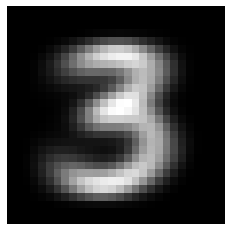

In [12]:
avg_imgA = train_imgsA.mean(0)
show_image(avg_imgA)

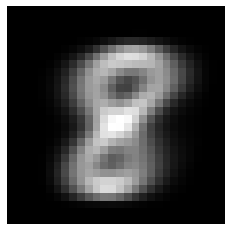

In [13]:
avg_imgB = train_imgsB.mean(0)
show_image(avg_imgB)

In [14]:
def mean_absolute_distance(one, two):
    return (one - two).abs().mean()

(tensor(0.3509), tensor(0.4229))

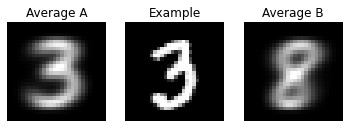

In [15]:
_, axes = plt.subplots(1, 3)

example = train_imgsA[0]

show_image(avg_imgA, ax=axes[0], title="Average A")
show_image(example, ax=axes[1], title="Example")
show_image(avg_imgB, ax=axes[2], title="Average B")

mean_absolute_distance(avg_imgA, example), mean_absolute_distance(avg_imgB, example)

(tensor(0.5108), tensor(0.4089))

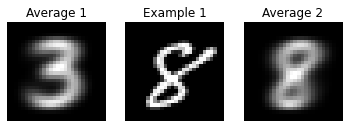

In [16]:
_, axes = plt.subplots(1, 3)

example = train_imgsB[0]

show_image(avg_imgA, ax=axes[0], title="Average 1")
show_image(example, ax=axes[1], title="Example 1")
show_image(avg_imgB, ax=axes[2], title="Average 2")

mean_absolute_distance(avg_imgA, example), mean_absolute_distance(avg_imgB, example)

In [17]:
distsAtoA = mean_absolute_distance(train_imgsA, avg_imgA)
distsAtoA.shape

torch.Size([])

In [18]:
def mean_absolute_distance(one, two):
    return (one - two).abs().mean((-1, -2))

In [19]:
distsAtoA = mean_absolute_distance(train_imgsA, avg_imgA)
distsAtoA.shape

torch.Size([6131])

In [20]:
def is_classA(img):
    return mean_absolute_distance(img, avg_imgA) < mean_absolute_distance(img, avg_imgB)

In [21]:
valid_imgs, valid_trgs = next(iter(valid_loader))
valid_imgsA = valid_imgs[valid_trgs == classA].squeeze()
valid_imgsB = valid_imgs[valid_trgs == classB].squeeze()
valid_imgsA.shape, valid_imgsB.shape

(torch.Size([1010, 28, 28]), torch.Size([974, 28, 28]))

In [22]:
correctA = is_classA(valid_imgsA)
correctA

tensor([False,  True,  True,  ...,  True,  True,  True])

In [23]:
correctA.shape

torch.Size([1010])

In [24]:
correctA.float().mean()

tensor(0.9178)

In [25]:
correctB = ~is_classA(valid_imgsB)

In [26]:
correctB.float().mean()

tensor(0.8696)

In [27]:
def get_mnist_loader(train: bool, path: str) -> Tuple[DataLoader, int]:
    """Return an MNIST dataloader for the two specified classes.

    Args:
        train (bool): Should this be a training set or validation set
        path (str): The directory in which to store/find the MNIST dataset

    Returns:
        Tuple[DataLoader, int]: Return a dataloader and its size
    """

    # All inputs must be converted into torch tensors, and the normalization values
    # have been precomputed and provided below.
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
    )

    dataset = MNIST(root=path, train=train, download=True, transform=mnist_transforms)
    loader = DataLoader(dataset, batch_size=len(dataset))
    return loader


def get_mnist_data(path: str) -> Tuple[DataLoader, int, DataLoader, int]:
    """Return data loaders for two classes from MNIST.

    Args:
        path (str): The directory in which to store/find the MNIST dataset

    Returns:
        Tuple[DataLoader, int, DataLoader, int]: Return a training dataloader the
            training set size (and the same for the validation dataset)
    """

    train_loader = get_mnist_loader(True, path)
    valid_loader = get_mnist_loader(False, path)

    return train_loader, valid_loader

In [28]:
train_loader, valid_loader = get_mnist_data('../data')
train_imgs, train_trgs = next(iter(train_loader))
valid_imgs, valid_trgs = next(iter(valid_loader))

In [29]:
classes = range(10)
avg_imgs = [train_imgs[train_trgs == cl].squeeze().mean(0) for cl in classes]

In [30]:
avg_imgs[0].shape

torch.Size([28, 28])

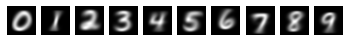

In [31]:
_, axes = plt.subplots(1, 10)
for avg_img, axes in zip(avg_imgs, axes):
    show_image(avg_img, ax=axes)

In [32]:
mean_absolute_distance(valid_imgs, avg_imgs[0]).shape

torch.Size([10000, 1])

In [33]:
valid_imgs.shape

torch.Size([10000, 1, 28, 28])

In [34]:
dists = [mean_absolute_distance(valid_imgs, avg_img) for avg_img in avg_imgs]

In [35]:
dists = torch.stack(dists, 1).squeeze()
dists.shape

torch.Size([10000, 10])

In [36]:
dists[:10,:]

tensor([[0.5743, 0.4068, 0.5302, 0.4990, 0.4293, 0.4776, 0.5303, 0.2837, 0.4958,
         0.3792],
        [0.6442, 0.4751, 0.5421, 0.5316, 0.6463, 0.5477, 0.5334, 0.6494, 0.5788,
         0.6310],
        [0.5896, 0.1678, 0.4487, 0.4337, 0.4246, 0.4204, 0.4368, 0.3917, 0.4374,
         0.4091],
        [0.4168, 0.5959, 0.5761, 0.5601, 0.5724, 0.5235, 0.4903, 0.5245, 0.5663,
         0.5366],
        [0.5640, 0.4741, 0.4968, 0.5316, 0.3624, 0.4934, 0.4752, 0.4212, 0.5053,
         0.4019],
        [0.6071, 0.1657, 0.4616, 0.4329, 0.4429, 0.4365, 0.4728, 0.3942, 0.4271,
         0.4119],
        [0.6274, 0.4409, 0.5554, 0.4833, 0.3897, 0.4614, 0.5287, 0.4035, 0.4771,
         0.3991],
        [0.6324, 0.4036, 0.5436, 0.4950, 0.4156, 0.4626, 0.4631, 0.4514, 0.4918,
         0.3901],
        [0.5841, 0.4908, 0.5458, 0.6139, 0.5077, 0.5429, 0.5191, 0.5672, 0.5623,
         0.5235],
        [0.5876, 0.4721, 0.5913, 0.5714, 0.4282, 0.5138, 0.5270, 0.3907, 0.4959,
         0.3889]])

In [37]:
_, predictions = dists.min(1)

In [38]:
valid_trgs.shape, predictions.shape

(torch.Size([10000]), torch.Size([10000]))

In [39]:
valid_trgs == predictions

tensor([ True, False,  True,  ..., False, False,  True])

In [40]:
(valid_trgs == predictions).float().mean()

tensor(0.6685)

In [41]:
f"Accuracy of similarity classifier: {(valid_trgs == predictions).float().mean() * 100:.2f} %"

'Accuracy of similarity classifier: 66.85 %'